# Predicción Multi-Clase de Cirrosis - Código de Desarrollo

## 1. Importaciones 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from janitor import clean_names
import cloudpickle
import optuna

pd.set_option('display.float_format', lambda x: '%.5f' % x)

from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier

from scipy.stats import randint, uniform
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from math import ceil
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# Estilo para las visualizaciones

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
paleta = sns.color_palette('Purples')[1:4]
paleta2 = sns.color_palette('Purples')[1:8]
color = sns.color_palette('Purples')[3]

plt.rcParams['figure.subplot.hspace'] = 0.33  
plt.rcParams['figure.subplot.wspace'] = 0.33  

## 2. Extracción de Datos

In [3]:
train = pd.read_csv('train.csv', index_col='id')
train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.30000,316.00000,3.35000,172.00000,1601.00000,179.80000,63.00000,394.00000,9.70000,3.00000,D
1,2574,Placebo,19237,F,N,N,N,N,0.90000,364.00000,3.54000,63.00000,1440.00000,134.85000,88.00000,361.00000,11.00000,3.00000,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.30000,299.00000,3.55000,131.00000,1029.00000,119.35000,50.00000,199.00000,11.70000,4.00000,D
3,2576,Placebo,18460,F,N,N,N,N,0.60000,256.00000,3.50000,58.00000,1653.00000,71.30000,96.00000,269.00000,10.70000,3.00000,C
4,788,Placebo,16658,F,N,Y,N,N,1.10000,346.00000,3.65000,63.00000,1181.00000,125.55000,96.00000,298.00000,10.60000,4.00000,C


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float64
 18  Status       

In [5]:
original = pd.read_csv('cirrhosis.csv', index_col = 'ID')
original.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.50000,261.00000,2.60000,156.00000,1718.00000,137.95000,172.00000,190.00000,12.20000,4.00000
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.10000,302.00000,4.14000,54.00000,7394.80000,113.52000,88.00000,221.00000,10.60000,3.00000
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.40000,176.00000,3.48000,210.00000,516.00000,96.10000,55.00000,151.00000,12.00000,4.00000
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.80000,244.00000,2.54000,64.00000,6121.80000,60.63000,92.00000,183.00000,10.30000,4.00000
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.40000,279.00000,3.53000,143.00000,671.00000,113.15000,72.00000,136.00000,10.90000,3.00000


In [6]:
original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 1 to 418
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage          

In [7]:
s = original.pop('Status')
original['Status'] = s

# Concatenar train y original
train = pd.concat([train, original], axis = 0)
train = train.reset_index(drop = True)
train = clean_names(train)

In [8]:
categoricas = ['drug', 'sex', 'ascites', 'hepatomegaly', 'spiders', 'edema', 'stage']
numericas = ['n_days', 'age', 'bilirubin', 'cholesterol', 'albumin', 'copper', 'alk_phos', 'sgot', 'tryglicerides', 'platelets', 'prothrombin']

## 3. Limpieza de Datos

In [9]:
# Contar el número de valores nulos en cada columna
train.isna().sum().sort_values(ascending = False)

tryglicerides    136
cholesterol      134
copper           108
alk_phos         106
ascites          106
hepatomegaly     106
spiders          106
drug             106
sgot             106
platelets         11
stage              6
prothrombin        2
n_days             0
albumin            0
bilirubin          0
edema              0
sex                0
age                0
status             0
dtype: int64

In [10]:
# Registros que contengan, al menos, 4 variables nulas
train[train.isnull().sum(axis=1) > 4]

,n_days,drug,age,sex,ascites,hepatomegaly,spiders,edema,bilirubin,cholesterol,albumin,copper,alk_phos,sgot,tryglicerides,platelets,prothrombin,stage,status
8217,4062,NaN,21915,F,NaN,NaN,NaN,N,0.70000,NaN,3.65000,NaN,NaN,NaN,NaN,378.00000,11.00000,NaN,C
8218,3561,NaN,23741,F,NaN,NaN,NaN,S,1.40000,NaN,3.04000,NaN,NaN,NaN,NaN,331.00000,12.10000,4.00000,D
8219,2844,NaN,19724,F,NaN,NaN,NaN,N,0.70000,NaN,4.03000,NaN,NaN,NaN,NaN,226.00000,9.80000,4.00000,C
8220,2071,NaN,27394,F,NaN,NaN,NaN,S,0.70000,NaN,3.96000,NaN,NaN,NaN,NaN,NaN,11.30000,4.00000,D
8221,3030,NaN,22646,F,NaN,NaN,NaN,N,0.80000,NaN,2.48000,NaN,NaN,NaN,NaN,273.00000,10.00000,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,681,NaN,24472,F,NaN,NaN,NaN,N,1.20000,NaN,2.96000,NaN,NaN,NaN,NaN,174.00000,10.90000,3.00000,D
8319,1103,NaN,14245,F,NaN,NaN,NaN,N,0.90000,NaN,3.83000,NaN,NaN,NaN,NaN,180.00000,11.20000,4.00000,C
8320,1055,NaN,20819,F,NaN,NaN,NaN,N,1.60000,NaN,3.42000,NaN,NaN,NaN,NaN,143.00000,9.90000,3.00000,C
8321,691,NaN,21185,F,NaN,NaN,NaN,N,0.80000,NaN,3.75000,NaN,NaN,NaN,NaN,269.00000,10.40000,3.00000,C


Hay 160 registros con 9 variables nulas, por lo que vamos a eliminarlos.

In [11]:
registros_eliminar = train[train.isnull().sum(axis=1) > 4].index
train = train.drop(index=registros_eliminar)
train.isna().sum()

n_days            0
drug              0
age               0
sex               0
ascites           0
hepatomegaly      0
spiders           0
edema             0
bilirubin         0
cholesterol      28
albumin           0
copper            2
alk_phos          0
sgot              0
tryglicerides    30
platelets         4
prothrombin       0
stage             0
status            0
dtype: int64

Vamos a imputar los nulos usando CatBoostRegressor, ya que todas las variables con nulos son numéricas.

In [12]:
# Columnas con nulos
cols_nulos = ['cholesterol', 'copper', 'tryglicerides', 'platelets']

# Preparación del dataset
status = train['status']
status_num = status.replace({'C': 0, 'D': 2, 'CL':1}).copy()
train = train.drop(columns = 'status')
train[categoricas] = train[categoricas].astype(str)

# Sustituir los valores nulos de cada columna por sus predicciones
for col in cols_nulos:
    # Encontrar el índice de los valores nulos y dividir entre train y test
    index_null = train[train[col].isna()].index
    x_train = train.loc[~train.index.isin(index_null)].drop(columns=col)
    y_train = train.loc[~train.index.isin(index_null), col]
    x_test = train.loc[train.index.isin(index_null)].drop(columns=col)

    # Establecer los parámetros del modelo
    cb_params = {
                'iterations': 500,
                'depth': 6,
                'learning_rate': 0.02,
                'l2_leaf_reg': 0.5,
                'random_strength': 0.2,
                'max_bin': 150,
                'od_wait': 80,
                'one_hot_max_size': 70,
                'grow_policy': 'Depthwise',
                'bootstrap_type': 'Bayesian',
                'od_type': 'IncToDec',
                'eval_metric': 'RMSE',
                'loss_function': 'RMSE',
                'random_state': 42,
            }

    # Instanciar el modelo y hacer las predicciones
    cat_nulos = CatBoostRegressor(**cb_params)
    cat_nulos.fit(x_train, y_train, cat_features=categoricas, verbose=False)
    y_pred = cat_nulos.predict(x_test)
    train.loc[train.index.isin(index_null), col] = y_pred

print('Nulos después de hacer la imputación: ', train.isna().sum().sum())

Nulos después de hacer la imputación:  0


## 4. Exploratory Data Analysis

### 4.1. Análisis de la variable objetivo, 'status'

In [13]:
status.value_counts()

status
C     5133
D     2790
CL     294
Name: count, dtype: int64

Observamos que la variable objetivo, 'status', no está balanceada. Comentaré este punto más adelante.

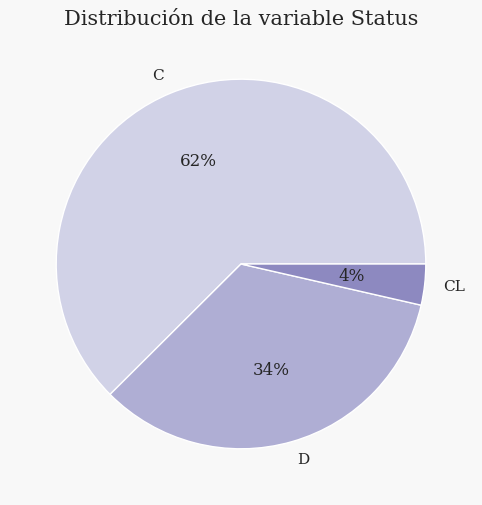

In [14]:
# Crear un gráfico de sectores con la distribución de la variable 'status'.
plt.figure(figsize = (12,6))
plt.pie(status.value_counts().values, labels=status.value_counts().index, autopct='%.0f%%', colors = paleta)
plt.title('Distribución de la variable Status', fontsize=15)
plt.show()

### 4.2. Análisis de las variables categóricas

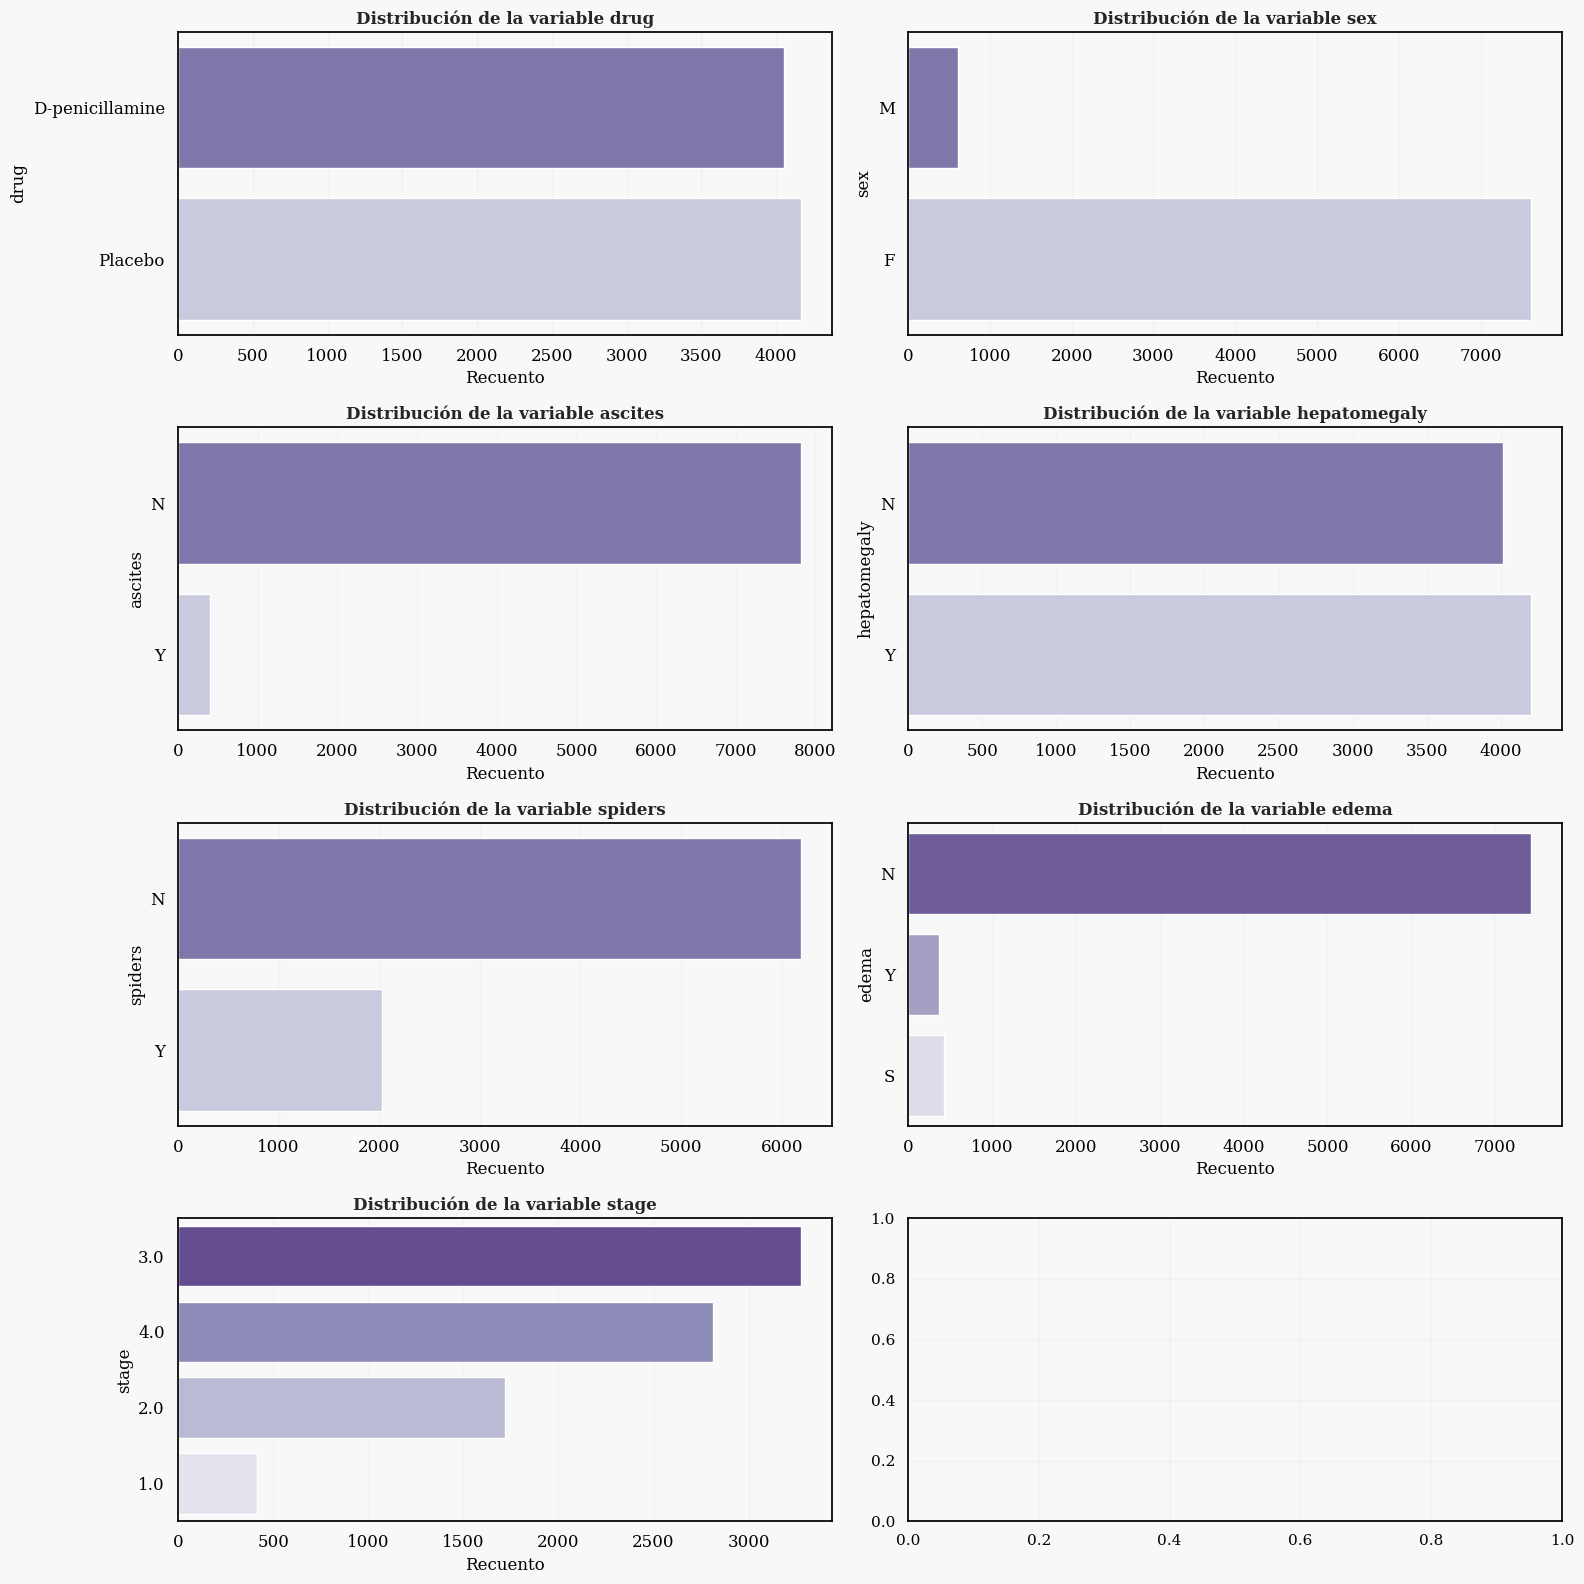

In [15]:
# Crear una función para generar gráficos que representen la distribución de cada variable categórica
def graficos_eda_categoricos(cat):
    # Calculamos el número de filas que necesitamos
    filas = ceil(cat.shape[1] / 2)

    # Definimos el gráfico
    f, ax = plt.subplots(nrows=filas, ncols=2, figsize=(16, filas * 4))

    # Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
    ax = ax.flat 

    # Creamos el bucle que va añadiendo gráficos
    for cada, variable in enumerate(cat):
        sns.countplot(y=cat[variable], ax=ax[cada], palette='Purples_r')
        ax[cada].set_title('Distribución de la variable ' + variable, fontsize=12, fontweight="bold")
        ax[cada].set_xlabel('Recuento')
        ax[cada].tick_params(labelsize=12)

graficos_eda_categoricos(train[categoricas])
plt.tight_layout()
plt.show()

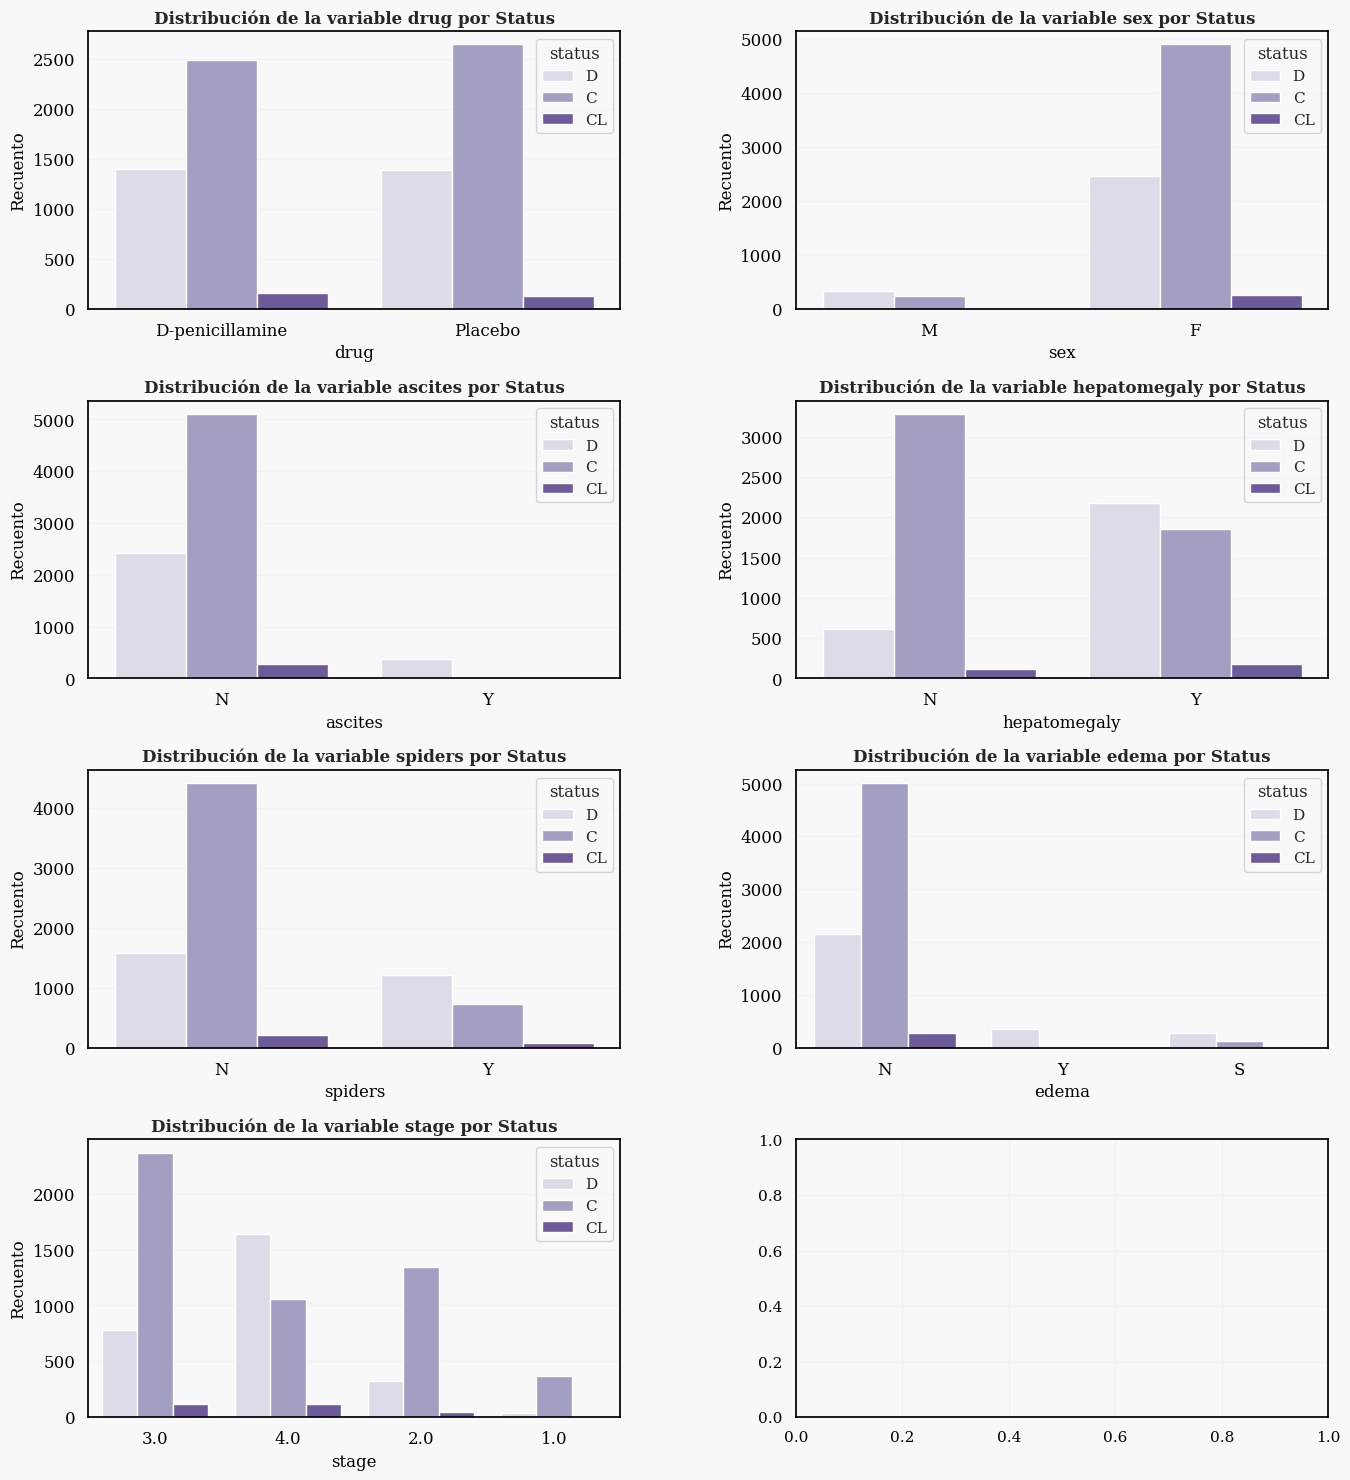

In [16]:
# Crear una función para generar gráficos que representen la distribución de cada variable categórica en función de la variable 'status'
def graficos_status(cat_col):
    f, ax = plt.subplots(nrows = int((len(cat_col)+1)/2) , ncols = 2, figsize = (16, int(len(cat_col)/2) * 6))
    ax = ax.flat 
    for cada, variable in enumerate(cat_col):
        sns.countplot(pd.concat([train[categoricas], status], axis = 1), x=variable, hue='status', ax=ax[cada], palette = 'Purples');
        ax[cada].set_title('Distribución de la variable ' + variable + ' por Status', fontsize=12, fontweight="bold")
        ax[cada].set_ylabel('Recuento')
        ax[cada].tick_params(labelsize = 12)

graficos_status(categoricas)

Conclusiones a partir de estos gráficos:

1. **No existe diferencia en el Status según el tipo de droga:*
s. El tipo de droga administrada parece no tener una influencia significativa en el resultado de los pacientes.

2. **En promedio, los hombres tienen una tasa de mortalidad más alta que las mujeres, a pesar de que hay más mujeres en el conjunto de datos:**
   Aunque la cantidad de mujeres en el conjunto de datos sea mayor, se percibe que, en promedio, los hombres tienen una tasa de mortalidad más alta. Esto sugiere que el género podría ser un factor que influye en el resultado del paciente.

3. **La gran mayoría de las personas que tienen ascitis fallecen:**
   Existe una correlación notable entre la presencia de ascitis y la mortalidad. La mayoría de las personas que tienen ascitis en el conjunto de datos parecen fallecer.

4. **Hepatomegalia y las arañas influyen en el Status:**
   La presencia de hepatomegalia y arañas en los pacientes parece estar asociada con el resultado del paciente (Status). Estos síntomas podrían ser indicativos de un resultado más grave.

5. **Personas con edema a pesar de una terapia diurética tienden a fallecer en su mayoría:**
   La presencia de edema a pesar de recibir terapia diurética parece estar relacionada con una alta tasa de mortalidad. Esto sugiere que, en estos casos, la terapia diurética podría no estar siendo efectiva o que la condición despecialmente grave.iente es especi

Estas conclusiones son observaciones iniciales basadas en los gráficos proporcionados. Para validar estas hipótesis, sería necesario realizar un análisis más detallado y posiblemente un análisis estadístico para establecer relaciones más sólidas entre las variables y los resultados observados. En la creación del modelo, veremos cuáles son las variables que más impacto tienen en el Status.almente grave.
tados observados.

### 4.3. Análisis de las variables numéricas

In [17]:
train[numericas].describe()

,n_days,age,bilirubin,cholesterol,albumin,copper,alk_phos,sgot,tryglicerides,platelets,prothrombin
count,8217.00000,8217.00000,8217.00000,8217.00000,8217.00000,8217.00000,8217.00000,8217.00000,8217.00000,8217.00000,8217.00000
mean,2029.26920,18369.20884,2.61961,351.12139,3.54725,84.41792,1823.04488,114.90653,115.64984,265.10819,10.63311
std,1095.29022,3686.95425,3.84440,196.46434,0.34927,76.31947,1913.38869,49.13407,52.95872,87.75946,0.79147
min,41.00000,9598.00000,0.30000,120.00000,1.96000,4.00000,289.00000,26.35000,33.00000,62.00000,9.00000
25%,1230.00000,15574.00000,0.70000,248.00000,3.35000,39.00000,834.00000,75.95000,84.00000,210.00000,10.00000
50%,1832.00000,18701.00000,1.10000,299.00000,3.58000,63.00000,1181.00000,108.50000,104.00000,265.00000,10.60000
75%,2689.00000,20684.00000,3.00000,390.00000,3.77000,102.00000,1857.00000,137.95000,139.00000,316.00000,11.00000
max,4795.00000,28650.00000,28.00000,1775.00000,4.64000,588.00000,13862.40000,457.25000,598.00000,563.00000,18.00000


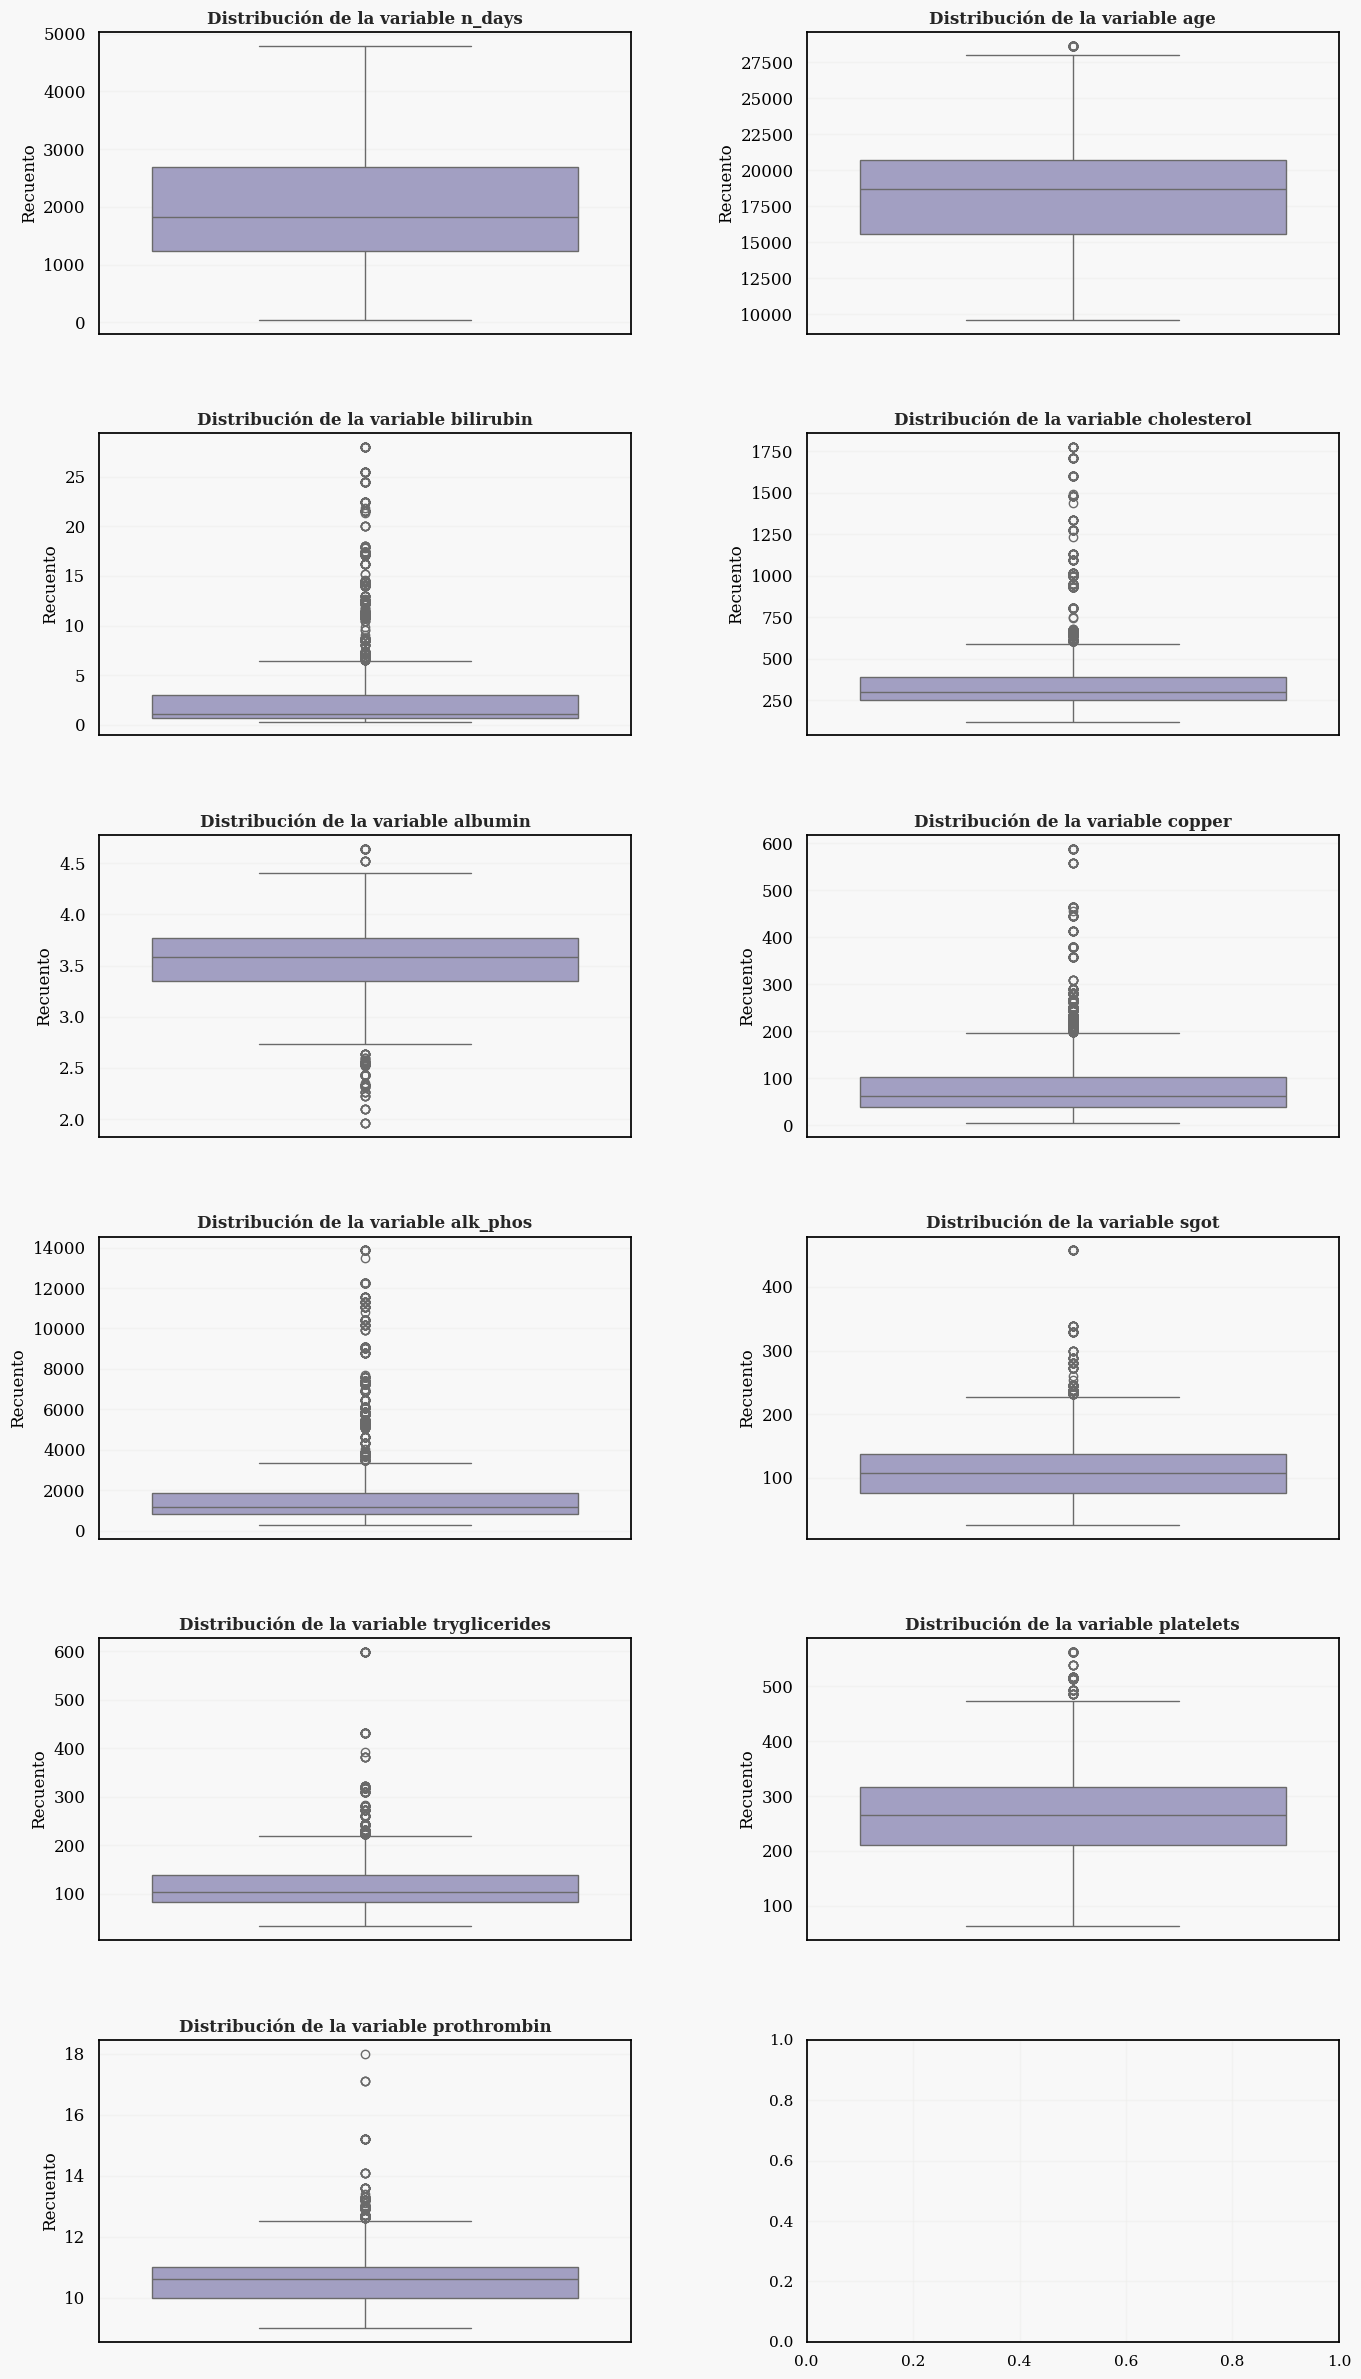

In [18]:
# Crear una función para generar gráficos boxplot que representen la distribución de cada variable numérica
def boxplot(num_col):
    f, ax = plt.subplots(nrows = int((len(num_col)+1)/2) , ncols = 2, figsize = (16, int(len(num_col)/2) * 6))
    ax = ax.flat 
    for cada, variable in enumerate(num_col):
        sns.boxplot(train[variable], ax=ax[cada], palette = 'Purples');
        ax[cada].set_title('Distribución de la variable ' + variable, fontsize=12, fontweight="bold")
        ax[cada].set_ylabel('Recuento')
        ax[cada].tick_params(labelsize = 12)

boxplot(numericas)

Se ha identificado la presencia de valores atípicos en todas las variables relacionadas con resultados médicos, como el colesterol o los triglicéridos, entre otros. Estos valores atípicos podrían representar mediciones inusuales, extremas o errores que se apartan significativamente del patrón general de datos.

En apartados posteriores, abordaremos y trataremos el tema de estos valores atípicos. Es fundamental comprender la naturaleza y el impacto de estos valores en nuestros análisis, ya que podrían influir en la precisión de los modelos y en la interpretación de los resultados.

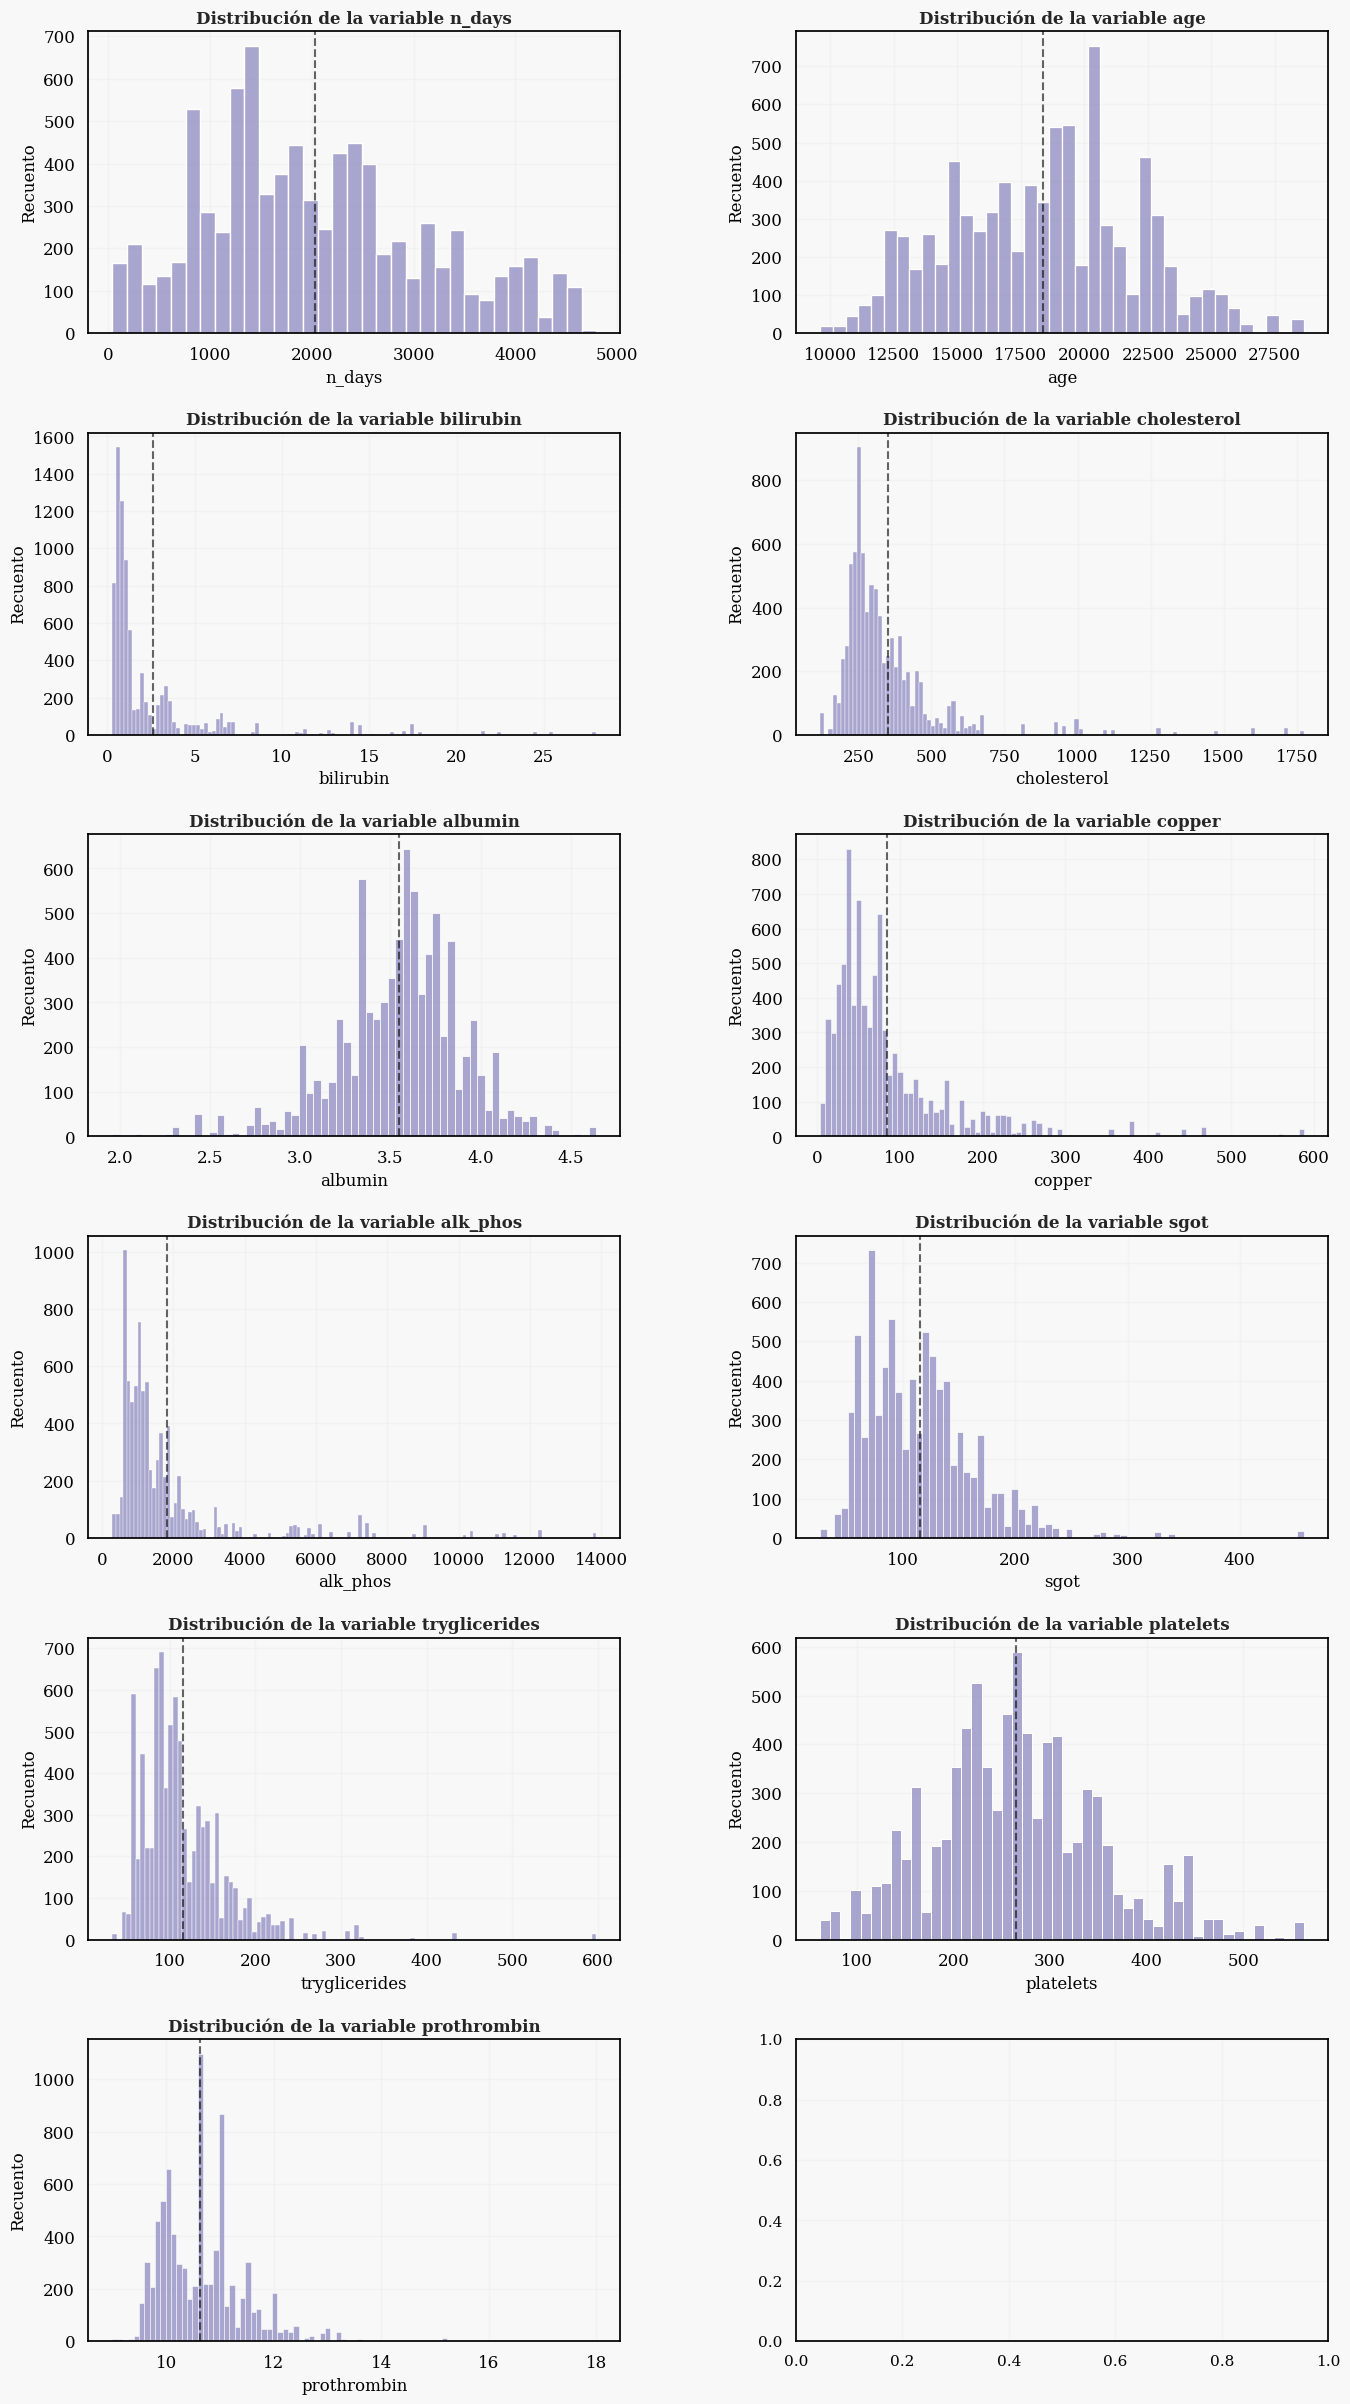

In [19]:
# Crear una función para generar gráficos que representen la distribución de cada variable numérica
def hisplot(num_col):
    f, ax = plt.subplots(nrows = int((len(num_col)+1)/2) , ncols = 2, figsize = (16, int(len(num_col)/2) * 6))
    ax = ax.flat 
    for cada, variable in enumerate(num_col):
        sns.histplot(train[variable], ax=ax[cada], color = color);
        ax[cada].set_title('Distribución de la variable ' + variable, fontsize=12, fontweight="bold")
        ax[cada].set_ylabel('Recuento')
        ax[cada].tick_params(labelsize = 12)
        ax[cada].axvline(train[variable].mean(), color = 'black', ls = '--', alpha = 0.6)

hisplot(numericas)

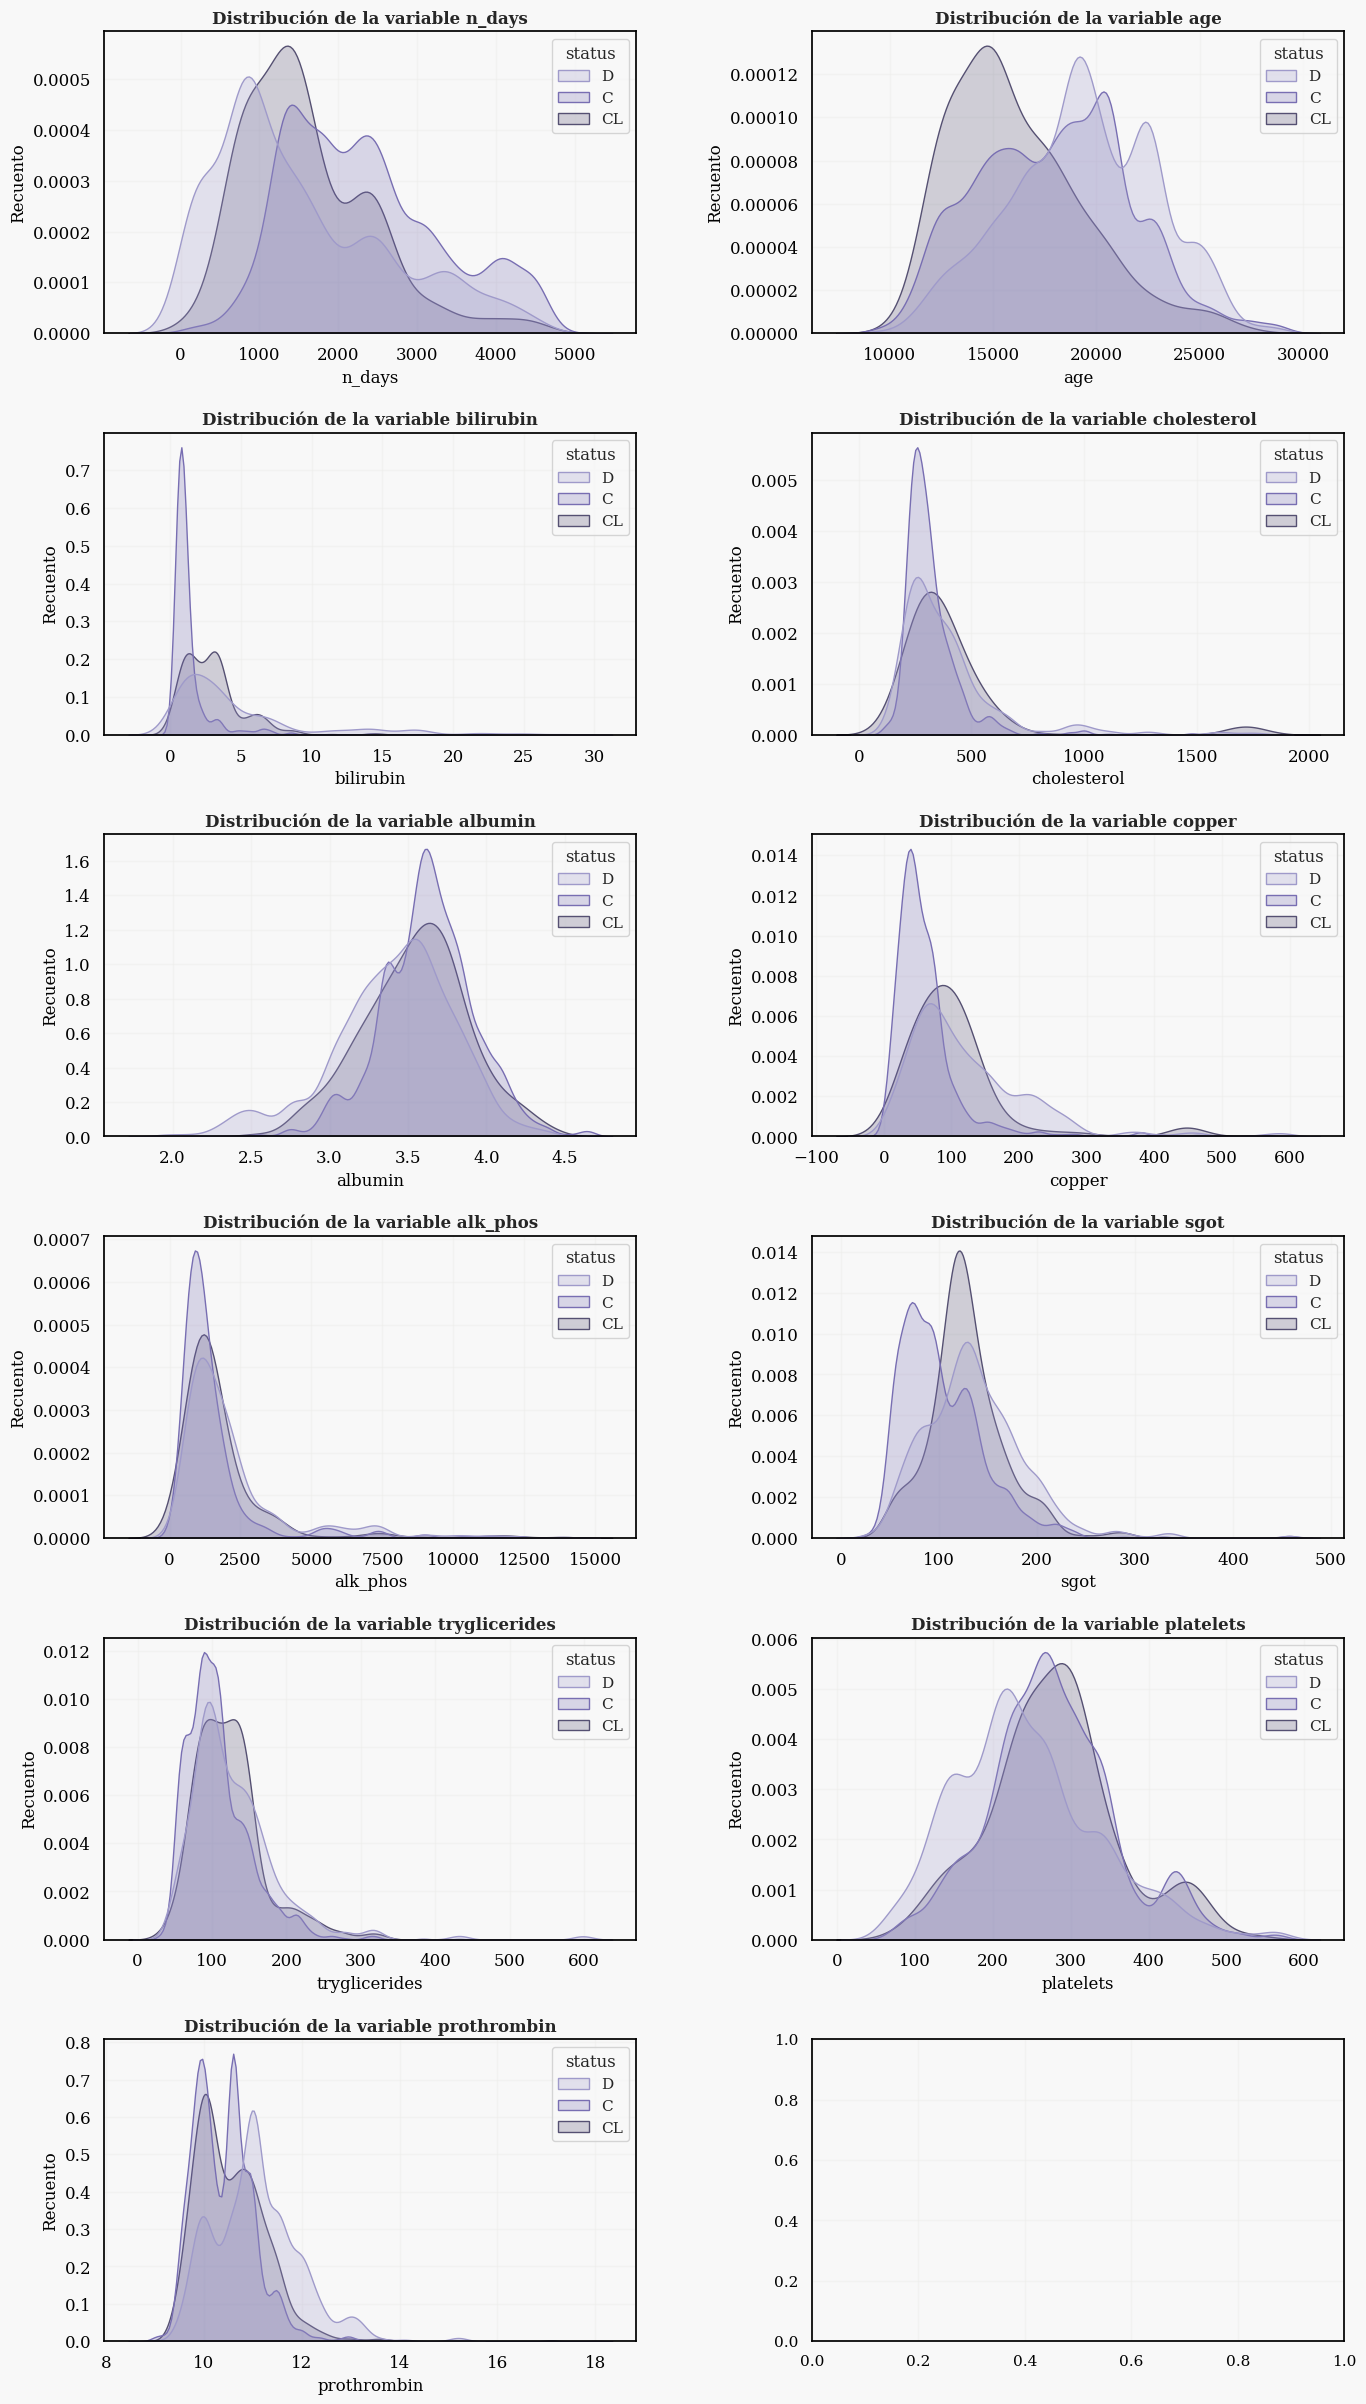

In [20]:
# Crear una función para generar gráficos que representen la distribución de cada variable numérica en función de la variable 'status'
def kdeplot(num_col):
    f, ax = plt.subplots(nrows=int((len(num_col) + 1) / 2), ncols=2, figsize=(16, int(len(num_col) / 2) * 6))
    ax = ax.flat
    for cada, variable in enumerate(num_col):
        sns.kdeplot(data=pd.concat([train[numericas], status], axis = 1), x=variable, hue='status', fill=True, common_norm=False, ax=ax[cada], palette='Purples_d')
        ax[cada].set_title('Distribución de la variable ' + variable, fontsize=12, fontweight="bold")
        ax[cada].set_ylabel('Recuento')
        ax[cada].tick_params(labelsize=12)

kdeplot(numericas)
plt.show()

Conclusiones básicas a partir de estos gráficos:
- Las personas más jóvenes tienen más posibilidades de sobrevivir gracias a un transplante de hígado
- A simple vista, las variables que más pueden influir en el resultado son 'bilirubin', 'copper', 'sgot' y 'platelets'

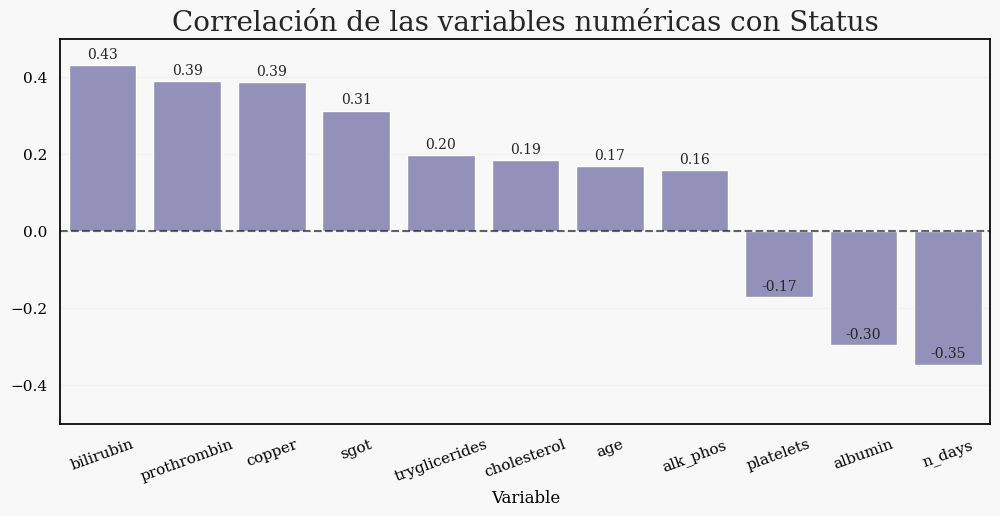

In [21]:
# Crear la matriz de correlación
df_num = pd.concat([train[numericas], status_num], axis=1)
corr = df_num.corr()['status'].sort_values(ascending=False).iloc[1:]

plt.figure(figsize=(12, 5))
barplot = sns.barplot(x=corr.index, y=corr.values, color=color)

plt.title('Correlación de las variables numéricas con Status', fontsize=20)
plt.xlabel('Variable')
plt.tick_params(axis='x', rotation=20)
plt.ylim(-0.5,0.5)
plt.axhline(0, ls = '--', color = 'black', alpha = 0.6)

# Añadir los valores de correlación en las barras
for index, value in enumerate(corr.values):
    barplot.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()


Podemos observar que no existe una correlación significativa entre las variables numéricas y la target.

## 5. Gestión de atípicos

En fases anteriores del proyecto, implementé un proceso para eliminar los valores atípicos del conjunto de datos. No obstante, esta acción no produjo mejoras significativas en el modelo, todo lo contrario, empeoró el resultado. Es por esto, que he optado por no llevar a cabo la eliminación de estos valores. Sin embargo, dejo aqui una celda comentada con el código que usé en su momento.


En este código lo que hago es eliminar los registros que se encuentran más allá de 5 desviaciones típicas de la media de cada variable.

In [22]:
# var_atipicos_dt = ['bilirubin', 'cholesterol', 'albumin', 'copper', 'alk_phos', 'sgot', 'tryglicerides', 'platelets', 'prothrombin']
# num_desv_tip = 5
# 
# print(train.shape)
# 
# def atipicos_desv_tip(variable, num_desv_tip = 4):
#     media = np.mean(variable)
#     sd = np.std(variable)
#     umbral = sd * num_desv_tip
#     lim_inf = media - umbral
#     lim_sup = media + umbral
#     #encontramos los índices de los que están fuera de los límites
#     indices = [indice for indice,valor in variable.items() if valor < lim_inf or valor > lim_sup]
#     return(indices)
# 
# for variable in var_atipicos_dt:
#     train.drop(atipicos_desv_tip(train[variable], num_desv_tip),axis = 0, inplace = True)

## 6. Creación de variables

Al igual que con la gestión de atípicos, la creación de nuevas variables solo empeoró el resultado. Este es el código, las variables que cree. 

Solo he añadido una nueva variable que se verá más adelante.

In [23]:
# train['age_years'] = round(train.age/365)
# train['age_years'] = train['age_years'].astype('int')
# 
# train['fecha_registro'] = round((train.age - train.n_days)/365)
# train['fecha_registro'] = train['fecha_registro'].astype('int')
# 
# numericas_media = ['bilirubin', 'cholesterol', 'albumin', 'copper', 'alk_phos', 'sgot', 'tryglicerides', 'platelets', 'prothrombin']
# train['media_num'] = train[numericas_media].mean(axis = 1)
# 
# train['bil_alb_rat'] = train.bilirubin / train.albumin
# train['ldi'] = (train.sgot + train.alk_phos)/2
# train['try_cho_rat'] = train.tryglicerides / train.cholesterol
# train['pla_pro_rat'] = train.platelets / train.prothrombin
# train['alk_bil_rat'] = train.alk_phos / train.bilirubin

## 7. Transformación de variables

En la preparación de los datos, se llevará a cabo la transformación de las variables categóricas para su posterior uso en modelos de machine learning.

Para las variables nominales, todas menos 'stage', se aplicará el método `OneHotEncoder`. Por otro lado, para la única variable ordinal, 'stage', se empleará el método `OrdinalEncoder`, manteniendo así, el orden de sus categorías.

Ambos procesos permitirán transformar las variables categóricas en representaciones numéricas para que puedan ser leídas por los modelos de machine learning.

In [24]:
var_ohe = categoricas[:-1]

# Aplicar OneHotEncoder a las variables nominales
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore', drop='first')
cat_ohe = ohe.fit_transform(train[var_ohe])
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

# Aplicar OrdinalEncoder a la variable ordinal
encoder = OrdinalEncoder()
train['stage_enc'] = encoder.fit_transform(train[['stage']])

train = train.drop(columns = categoricas)
train = pd.concat([train, cat_ohe], axis = 1)

In [25]:
# La única variable que he creado
train['sum_cat'] = train[['ascites_Y', 'hepatomegaly_Y', 'spiders_Y']].sum(axis=1)

## 8. Reescalado de las variables

Para hacer el reescalado de las variables voy a utilizar `StandardScaler`, que transforma las variables para que tengan una media de 0 y una desviación estándar de 1. De esta forma, los datos se ajustan para tener una escala uniforme, lo que ayuda a mejorar el rendimiento de los modelos.

In [26]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(train)
train = pd.DataFrame(df_scaled, columns=train.columns.to_list())

## 9. Balanceo de la variable target

En el conjunto de datos, se identificó que la variable objetivo ('target') no está balanceada, ya que existe una notable disparidad en la cantidad de casos para cada categoría. La categoría 'CL' tiene muchos menos casos que las demás.

Para abordar este desequilibrio, consideré inicialmente aplicar técnicas de balanceo (`RandomUnderSampler`, `RandomOverSampler`, `SMOTETomek`) para igualar el número de casos para todas las categorías de la variable objetivo. Sin embargo, al equilibrar las categorías, aumentó el sobreajuste en el modelo.

El sobreajuste implica que el modelo aprende demasiado específicamente los datos de entrenamiento, limitando su capacidad para generalizar a nuevos datos. Por esta razón, tomé la decisión de no llevar a cabo el balanceo de la variable objetivo.

## 9. Modelización

Para realizar las predicciones, implementaré un método de Ensembling utilizando `VotingClassifier`. Esta técnica permite generar una predicción final combinando las predicciones individuales de varios modelos, lo que puede ayudar a reducir el sobreajuste y mejorar la generalización del modelo.

Los modelos seleccionados para este proceso de Ensembling son: XGBoost, LightGBM y CatBoost. 

El objetivo de esta estrategia es aprovechar las fortalezas de cada modelo individual y obtener un resultado más robusto al combinar sus predicciones. Esto puede conducir a una mejor capacidad predictiva y a una reducción del sobreajuste, proporcionando una predicción más confiable en conjunto.

In [27]:
# Hacer la división entre train y test
X_train, X_test, y_train, y_test = train_test_split(train, status, test_size=0.2, random_state=42)

### 9.1. Hiperparametrización

Para el proceso de optimización de hiperparámetros, utilicé la librería Optuna para encontrar los valores óptimos de los hiperparámetros de los modelos. A través del código de las siguientes celdas, logré obtener dichos valores.

Por motivos de rendimiento y de tiempo, he decidido comentar dichas celdas. En su lugar, he incluido los valores de los parámetros que obtuve.

In [28]:
# def objective(trial):
#     params = {
#         'objective': 'multi:softprob',  # Cambiado a 'multi:softprob' para multiclase
#         'num_class': 3,
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.5, 10),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.5, 10),
#         'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10)
#     }
#     
#     model = XGBClassifier(**params)
#     score = cross_val_score(model, train, status, cv=5, scoring='neg_log_loss', n_jobs=-1)
#     return score.mean()
# 
# study = optuna.create_study(direction='maximize')  # Minimiza la función objetivo
# study.optimize(objective, n_trials=40)
# 
# xgb_params = study.best_params

In [29]:
# XGBoost
xgb_params = {'max_depth': 9, 
              'learning_rate': 0.011966796700210041, 
              'n_estimators': 812, 
              'subsample': 0.902125561162019, 
              'colsample_bytree': 0.5434520173899028, 
              'reg_alpha': 1.6657450049171036, 
              'reg_lambda': 1.3496554610392866, 
              'min_child_weight': 0.6681009306007859}
xgb_model = XGBClassifier(**xgb_params)

In [30]:
# def objective(trial):
#     params = {
#         'objective': 'multiclass',  # Cambiado a 'multiclass' para multiclase
#         'num_class': 3,
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.1, 2),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 2),
#         'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10)
#     }
#     
#     model = lgb.LGBMClassifier(**params)
#     score = cross_val_score(model, train, status, cv=10, scoring='neg_log_loss', n_jobs=-1)
#     return score.mean()
# 
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=40)
# 
# lgb_params = study.best_params

In [31]:
# LightGBM
lgb_params = {'max_depth': 10, 
              'learning_rate': 0.028708783003621362, 
              'n_estimators': 597, 
              'subsample': 0.5416580380091157, 
              'colsample_bytree': 0.17078424697805134,
              'reg_alpha': 1.2445245633658277, 
              'reg_lambda': 1.4844177913140397, 
              'min_child_weight': 2.8846913624515373}
lgb_model = lgb.LGBMClassifier(**lgb_params, verbose = -1)

In [32]:
# def objective(trial):
#     params = {
#         'depth': trial.suggest_int('depth', 3, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.5, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
#         'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
#         'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli'])
#     }
#     
#     model = CatBoostClassifier(**params)
#     score = cross_val_score(model, train, status, cv=5, scoring='neg_log_loss', n_jobs=-1)
#     return score.mean()
# 
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=40)
# 
# cat_params = study.best_params

In [33]:
# CatBoost
cat_params = {'depth': 4, 
              'learning_rate': 0.039468114494012996, 
              'iterations': 891, 
              'subsample': 0.835679044792754, 
              'colsample_bylevel': 0.9982911515260249, 
              'reg_lambda': 1.4, 
              'min_child_samples': 20, 
              'grow_policy': 'Lossguide', 
              'bootstrap_type': 'Bernoulli'}
cat_model = CatBoostClassifier(**cat_params, verbose=0)

### 9.2. Validación del modelo

In [34]:
# Instanciar el modelo con VotingClassifier añadiendole los tres modelos anteriores
voting_clf = VotingClassifier(estimators=[('xgb', xgb_model), ('lgb', lgb_model), ('cat', cat_model)], 
                              voting='soft', weights = [0.35,0.50,0.15], verbose = 0, n_jobs = -1)

# Realizar la validación cruzada
scores = cross_val_score(voting_clf, X_train, y_train, cv=10, scoring='neg_log_loss', verbose=0)
print("Puntajes de la validación cruzada:", scores)
print("Precisión media: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Puntajes de la validación cruzada: [-0.39265851 -0.43369268 -0.43197904 -0.42266728 -0.42036538 -0.45888199
 -0.40424771 -0.44403881 -0.40906387 -0.41841539]
Precisión media: -0.42360 (+/- 0.04)


### 9.3. Entrenamiento del modelo

In [35]:
# Entrenar el modelo sobre los datos de entrenamiento
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5434520173899028,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=No...
                              LGBMClassifier(colsample_bytree=0.17078424697805134,
                                             learning_rate=0.028708783003621362,
                                             max_depth=10,
                                             min_child_weight=2.8846913624515373,
                                             n_estimators=597,
                                             reg_alpha=1.2445245633658277,
                                             reg_lambda=1.4844177913140397,
                                             subsample=0.5416580380091157,
                                             verbose=-1)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x000002C291DF6F90>)],
                 n_jobs=-1, verbose=0, voting='soft',
                 weights=[0.35, 0.5, 0.15])

### 9.4. Resultados del modelo

In [36]:
# Hacer las predicciones sobre los datos de validación
y_pred = voting_clf.predict_proba(X_test)
logloss = log_loss(y_test, y_pred)

# Imprimir el log loss
print(f"El log loss es: {logloss}")

El log loss es: 0.4008239503179859


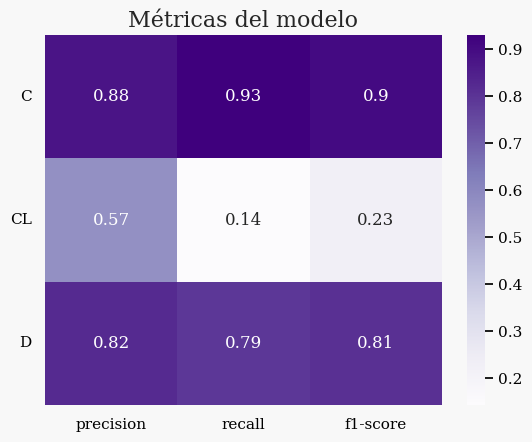

In [37]:
# Visualizar las métricas principales
y_pred = voting_clf.predict(X_test)
clf = classification_report(y_test, y_pred, target_names=['C', 'CL', 'D'], output_dict=True)
sns.heatmap(pd.DataFrame(clf).iloc[:-1, :-3].T, annot=True, cmap='Purples')
plt.title('Métricas del modelo', fontsize = 16)
plt.tick_params(axis='y',labelrotation = 0)

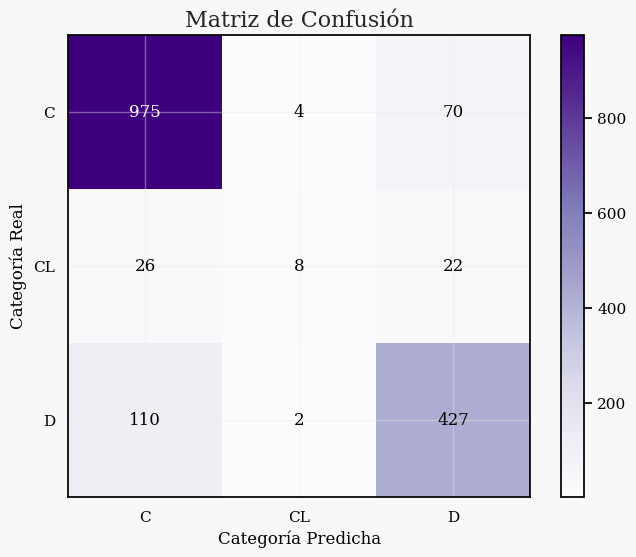

In [38]:
# Hacer la matriz de confusión
y_pred = pd.Series(voting_clf.predict(X_test)).replace({'C': 0, 'D': 2, 'CL':1})
y_test = y_test.replace({'C': 0, 'D': 2, 'CL':1})
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

# Crear el heatmap
heatmap = plt.imshow(cm, interpolation='nearest', cmap='Purples')
plt.colorbar(heatmap)

# Añadir etiquetas y título
plt.xticks([0, 1, 2], ['C', 'CL', 'D'])
plt.yticks([0, 1, 2], ['C', 'CL', 'D'])
plt.xlabel('Categoría Predicha')
plt.ylabel('Categoría Real')
plt.title('Matriz de Confusión', fontsize = 16)

# Añadir los valores en las celdas
for i in range(len(cm)):
    for j in range(len(cm[0])):
        if i == 0 and j == 0:
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=12)
        else:
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black', fontsize=12)

# Mostrar la matriz de confusión
plt.show()

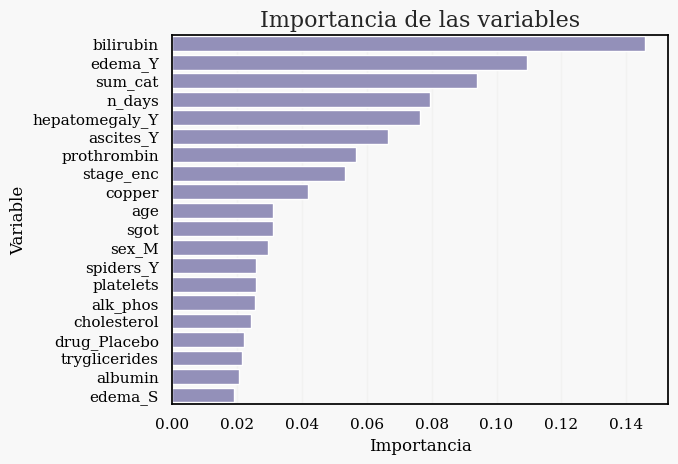

In [39]:
# Hacer una gráfica con la importancia de las variables en el modelo
importances = voting_clf.named_estimators_['xgb'].feature_importances_
feature_names = train.columns

feature_importance_df = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})
feature_importance_df = feature_importance_df.sort_values('Importancia', ascending=False)

sns.barplot(feature_importance_df, x='Importancia', y='Variable', color=color)
plt.title('Importancia de las variables', fontsize=16);

### 9.5. Reentrenamiento del modelo

In [40]:
# Entrenar el modelo sobre todo el conjunto de datos
voting_clf.fit(train, status)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5434520173899028,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=No...
                              LGBMClassifier(colsample_bytree=0.17078424697805134,
                                             learning_rate=0.028708783003621362,
                                             max_depth=10,
                                             min_child_weight=2.8846913624515373,
                                             n_estimators=597,
                                             reg_alpha=1.2445245633658277,
                                             reg_lambda=1.4844177913140397,
                                             subsample=0.5416580380091157,
                                             verbose=-1)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x000002C291DF6F90>)],
                 n_jobs=-1, verbose=0, voting='soft',
                 weights=[0.35, 0.5, 0.15])

In [41]:
# Guardar el modelo
with open('modelo_final.pkl', 'wb') as archivo:
    cloudpickle.dump(voting_clf, archivo)

## 10. Predicciones sobre test

Una vez entrenado el modelo, solo queda hacer las predicciones.

In [42]:
# Extracción de datos
test = pd.read_csv('test.csv')
ids = test[['id']]
test = test.drop(columns = 'id')
test = clean_names(test)

# Transformación de datos
cat_ohe = ohe.transform(test[var_ohe])
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

encoder = OrdinalEncoder()
test['stage_enc'] = encoder.fit_transform(test[['stage']])

test = test.drop(columns = categoricas)
test = pd.concat([test, cat_ohe], axis = 1)

# Creación de la única variable
test['sum_cat'] = test[['ascites_Y', 'hepatomegaly_Y', 'spiders_Y']].sum(axis = 1)

# Reescalado
df_sc = scaler.transform(test)
test = pd.DataFrame(df_sc,columns = test.columns.to_list())

# Predicciones
submission = pd.DataFrame(voting_clf.predict_proba(test))
submission.columns = ['Status_C', 'Status_Cl', 'Status_D']
submission = pd.concat([ids, submission], axis = 1)
submission

,id,Status_C,Status_Cl,Status_D
0,7905,0.36507,0.02299,0.61194
1,7906,0.51683,0.14343,0.33974
2,7907,0.03803,0.01603,0.94595
3,7908,0.97059,0.00364,0.02577
4,7909,0.87390,0.04493,0.08117
...,...,...,...,...
5266,13171,0.88022,0.07142,0.04836
5267,13172,0.97180,0.00494,0.02326
5268,13173,0.93159,0.00947,0.05894
5269,13174,0.98206,0.00700,0.01093


In [43]:
# Guardar las predicciones
submission.to_csv('final_submission.csv', index=False)